<a href="https://colab.research.google.com/github/alex-smith-uwec/CS491/blob/main/Visualizing%20Word2Vec%20Word%20Embeddings%20using%20t-SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1. Visualizing Similar Words from Google News

In [ ]:

##Be patient...this will take some time to download!
import gensim.downloader as api
model = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
import numpy as np
def linear_combination(word_scalars):
    """
    Perform a linear combination of word vectors.

    Parameters:
    - word_scalars (list of tuples): A list where each tuple contains a word (string) and a scalar (float or int).

    Returns:
    - np.array: The resulting vector from the linear combination.
    """
    # Initialize an empty vector for the result
    result_vector = np.zeros(model.vector_size)

    for word, scalar in word_scalars:
        # Check if the word is in the model
        if word in model:
            # Add (or subtract) the scaled vector to the result
            result_vector += model[word] * scalar
        else:
            print(f"Word '{word}' not in model vocabulary.")

    return result_vector



In [ ]:
# Example usage:
# Compute the vector for the expression: woman - 2*man + 3*girl
combination_vector = linear_combination([('calculus', 1), ('college', +2), ('biology', 1)])

# Find and print words most similar to the resulting vector
similar_words = model.most_similar(positive=[combination_vector], topn=5)
print(similar_words)

[('college', 0.7974893450737), ('calculus', 0.7319367527961731), ('biology', 0.6941104531288147), ('precalculus', 0.6479670405387878), ('pre_med', 0.6376080513000488)]


In [ ]:
keys = ['Paris', 'Python', 'Sunday', 'Tolstoy', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'peace', 'release', 'war']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

<ipython-input-7-b04aadfc13d1>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


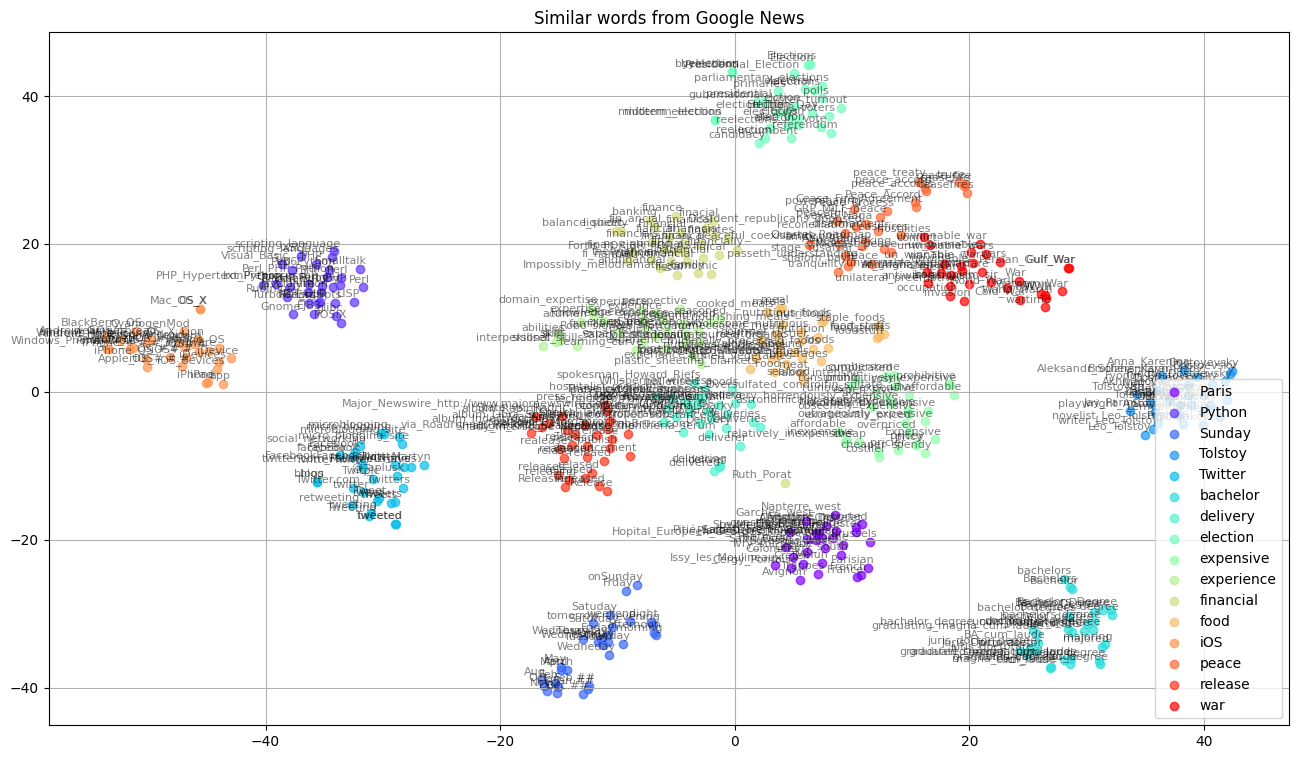

In [ ]:
import matplotlib.pyplot as plt
# import matplotlib.cm as cm matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Visualizing Word2Vec Vectors from a novel in English

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
my_path="/content/drive/MyDrive/CS491/Data/"

In [23]:
import re
import gensim
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords if not already downloaded and convert to set for faster access
nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
stop_words=set()##do not remove stop words


# Modify the regular expression for non-alphanumeric characters removal to also remove newlines, carriage returns, and tabs
non_alpha_numeric_re = re.compile('[\n\r\t]|[^a-zA-Z0-9\s]+')

def preprocess_text(text):
    # Use the compiled regex to remove non-alphanumeric characters except for spaces, and also newlines, carriage returns, and tabs
    text = non_alpha_numeric_re.sub(' ', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords using the set for faster lookup
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Return the preprocessed text
    return ' '.join(filtered_words).strip()

def prepare_for_w2v(filename_from, filename_to, lang='english', use_sentence_tokenization=True):
    with open(filename_from, "r", encoding='utf-8') as file:
        raw_text = file.read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        # Check if sentence tokenization is used
        if use_sentence_tokenization:
            sentences = nltk.sent_tokenize(raw_text, language=lang)
        else:
            sentences = [raw_text]  # Treat the entire text as a single sentence

        for sentence in sentences:
            processed_sentence = preprocess_text(sentence.lower())
            print(processed_sentence, file=f)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, vector_size=300, window=10, min_count=3, workers=4)  # Adjusted workers to 4 for potential parallel processing improvement

# Example usage with sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=True)

# Example usage without sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=False)

# Then, train the model as before
# model = train_word2vec('train_english_text.txt')

In [25]:
# Example usage with sentence tokenization
# prepare_for_w2v('path_to_your_input_file.txt', 'train_english_text.txt', 'english', use_sentence_tokenization=True)

# Example usage without sentence tokenization
prepare_for_w2v(my_path+'The Golden Bowl', 'train_english_text.txt', 'english', use_sentence_tokenization=False)

model = train_word2vec('train_english_text.txt')

In [26]:
import numpy as np
from sklearn.manifold import TSNE

# Assuming model is your trained Word2Vec model from gensim

words_model = []
embeddings_model = []

for word in model.wv.key_to_index:
    embeddings_model.append(model.wv[word])
    words_model.append(word)

embeddings_model_np = np.array(embeddings_model)

# Initialize and apply TSNE
tsne_model_2d = TSNE(perplexity=64, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_model_2d_np = tsne_model_2d.fit_transform(embeddings_model_np)


In [29]:
# @title
freq_words=[('would', 804),
 ('Maggie', 693),
 ('one', 659),
 ('Charlotte', 593),
 ('might', 578),
 ('could', 518),
 ('little', 464),
 ('even', 448),
 ('said', 444),
 ('made', 437),
 ('much', 433),
 ('time', 410),
 ('see', 389),
 ('Assingham', 373),
 ('know', 334),
 ('way', 333),
 ('quite', 322),
 ('come', 312),
 ('make', 296),
 ('still', 292),
 ('like', 290),
 ('yet', 279),
 ('say', 272),
 ('Prince', 266),
 ('really', 261),
 ('moment', 258),
 ('nothing', 255),
 ('think', 255),
 ('question', 252),
 ('never', 252),
 ('always', 249),
 ('something', 248),
 ('fact', 240),
 ('back', 240),
 ('things', 237),
 ('mean', 237),
 ('last', 234),
 ('Fanny', 234),
 ('father', 232),
 ('however', 227),
 ('almost', 224),
 ('without', 224),
 ('eyes', 223),
 ('felt', 217),
 ('Verver', 217),
 ('take', 214),
 ('enough', 213),
 ('must', 213),
 ('thing', 211),
 ('least', 206),
 ('together', 205),
 ('less', 203),
 ('everything', 200),
 ('first', 200),
 ('anything', 199),
 ('good', 194),
 ('knew', 193),
 ('sense', 188),
 ('Well', 188),
 ('husband', 188),
 ('thought', 187),
 ('Oh', 187),
 ('came', 186),
 ('though', 185),
 ('great', 183),
 ('done', 182),
 ('went', 182),
 ('long', 181),
 ('matter', 176),
 ('face', 175),
 ('looked', 174),
 ('put', 166),
 ('ever', 165),
 ('go', 165),
 ('may', 162),
 ('life', 160),
 ('took', 160),
 ('well', 159),
 ('dear', 158),
 ('friend', 158),
 ('idea', 156),
 ('rather', 156),
 ('far', 155),
 ('asked', 153),
 ('feel', 150),
 ('want', 150),
 ('kept', 150),
 ('course', 148),
 ('old', 148),
 ('taken', 147),
 ('Amerigo', 147),
 ('us', 144),
 ('seemed', 142),
 ('right', 142),
 ('indeed', 141),
 ('present', 139),
 ('place', 139),
 ('perhaps', 139),
 ('day', 138),
 ('man', 137),
 ('effect', 136),
 ('wife', 136),
 ('Ah', 133),
 ('young', 132),
 ('another', 132),
 ('give', 132),
 ('saw', 130),
 ('away', 129),
 ('look', 128),
 ('upon', 128),
 ('also', 126),
 ('Princess', 126),
 ('point', 125),
 ('found', 124),
 ('since', 122),
 ('let', 121),
 ('light', 121),
 ('minute', 119),
 ('left', 117),
 ('case', 117),
 ('two', 115),
 ('else', 115),
 ('particular', 115),
 ('hour', 114),
 ('already', 112),
 ('keep', 112),
 ('thus', 111),
 ('people', 111),
 ('whole', 109),
 ('high', 109),
 ('companion', 109),
 ('world', 108),
 ('seen', 107),
 ('added', 107),
 ('stood', 106),
 ('others', 105),
 ('given', 105),
 ('woman', 104),
 ('part', 104),
 ('hand', 103),
 ('either', 102),
 ('making', 102),
 ('gave', 101),
 ('speak', 100),
 ('better', 99),
 ('truth', 98),
 ('instant', 98),
 ('alone', 98),
 ('wanted', 98),
 ('round', 98),
 ('view', 97),
 ('brought', 97),
 ('sure', 97),
 ('occasion', 97),
 ('mind', 97),
 ('turned', 95),
 ('next', 95),
 ('Colonel', 95),
 ('best', 94),
 ('many', 94),
 ('help', 94),
 ('word', 94),
 ('side', 94),
 ('somehow', 92),
 ('every', 91),
 ('possible', 91),
 ('reason', 91),
 ('air', 91),
 ('words', 91),
 ('head', 90),
 ('taking', 90),
 ('got', 89),
 ('call', 89),
 ('whatever', 89),
 ('appeared', 87),
 ('new', 86),
 ('met', 86),
 ('find', 85),
 ('held', 85),
 ('show', 85),
 ('exactly', 85),
 ('relation', 84),
 ('home', 84),
 ('poor', 83),
 ('small', 83),
 ('able', 83),
 ('days', 82),
 ('known', 82),
 ('shall', 82),
 ('Yes', 82),
 ('end', 82),
 ('going', 82),
 ('told', 81),
 ('manner', 81),
 ('talk', 81),
 ('presence', 79),
 ('short', 78),
 ('turn', 78),
 ('spoke', 78),
 ('kind', 78)]

In [33]:
highlight_words = [item[0].lower() for item in freq_words]
print(highlight_words)

['would', 'maggie', 'one', 'charlotte', 'might', 'could', 'little', 'even', 'said', 'made', 'much', 'time', 'see', 'assingham', 'know', 'way', 'quite', 'come', 'make', 'still', 'like', 'yet', 'say', 'prince', 'really', 'moment', 'nothing', 'think', 'question', 'never', 'always', 'something', 'fact', 'back', 'things', 'mean', 'last', 'fanny', 'father', 'however', 'almost', 'without', 'eyes', 'felt', 'verver', 'take', 'enough', 'must', 'thing', 'least', 'together', 'less', 'everything', 'first', 'anything', 'good', 'knew', 'sense', 'well', 'husband', 'thought', 'oh', 'came', 'though', 'great', 'done', 'went', 'long', 'matter', 'face', 'looked', 'put', 'ever', 'go', 'may', 'life', 'took', 'well', 'dear', 'friend', 'idea', 'rather', 'far', 'asked', 'feel', 'want', 'kept', 'course', 'old', 'taken', 'amerigo', 'us', 'seemed', 'right', 'indeed', 'present', 'place', 'perhaps', 'day', 'man', 'effect', 'wife', 'ah', 'young', 'another', 'give', 'saw', 'away', 'look', 'upon', 'also', 'princess', '

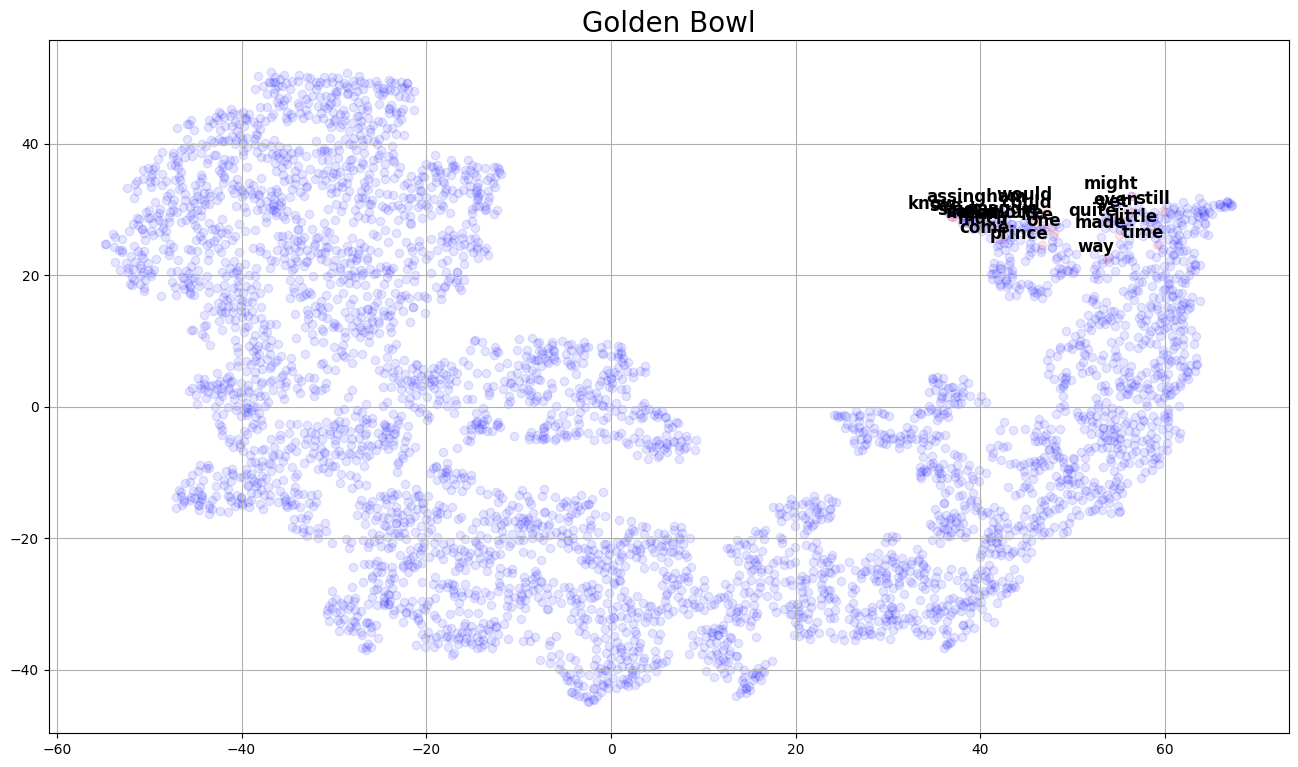

Number of points plotted: 4336


In [37]:
import matplotlib.pyplot as plt


def tsne_plot_2d(label, embeddings, words=[], a=1, highlight_words=highlight_words[0:25]):
    plt.figure(figsize=(16, 9))

    # Extract x and y coordinates
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    # Plot each point and annotate highlighted words
    for i, word in enumerate(words):
        color = 'red' if word in highlight_words else 'blue'
        plt.scatter(x[i], y[i], color=color, alpha=a)
        if word in highlight_words:
            plt.annotate(word, alpha=1.0, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom',
                         size=12, weight='bold')

    # Set the title of the plot with the given label
    plt.title(label, fontsize=20)

    plt.grid(True)
    plt.show()

    # Print the number of points
    num_points = embeddings.shape[0]
    print("Number of points plotted:", num_points)

# Example usage
tsne_plot_2d('Golden Bowl', embeddings_model_2d_np, words_model, a=0.1)


In [41]:
def find_words_in_grid(embeddings, words, x_min, x_max, y_min, y_max):
    """
    Finds and returns the words that are located within a specified grid area.

    Parameters:
    - embeddings: numpy array of shape (n, 2), where n is the number of points/words,
      containing the x and y coordinates of each word.
    - words: list of strings, containing the words corresponding to each point.
    - x_min, x_max, y_min, y_max: float, boundaries of the grid area.

    Returns:
    - list of words that are within the specified grid area.
    """
    # Extract x and y coordinates
    x = embeddings[:, 0]
    y = embeddings[:, 1]

    # Initialize an empty list to store words within the grid
    words_in_grid = []

    # Loop through each point and check if it falls within the specified grid area
    for i, word in enumerate(words):
        if x_min <= x[i] <= x_max and y_min <= y[i] <= y_max:
            words_in_grid.append(word)

    return words_in_grid

# Example usage (specify the grid boundaries as needed)
x_min, x_max = -40, -20  # Example boundaries
y_min, y_max = 45, 55  # Example boundaries
words_in_grid = find_words_in_grid(embeddings_model_2d_np, words_model, x_min, x_max, y_min, y_max)
print("Words in specified grid area:", words_in_grid)



Words in specified grid area: ['restless', 'proposing', 'wedding', 'earnestness', 'concealed', 'doubts', 'deciding', 'restored', 'backed', 'deserved', 'unexplained', 'drops', 'conclusive', 'comfortably', 'sublimely', 'declined', 'invitation', 'rush', 'refer', 'quoted', 'significant', 'distorted', 'practising', 'hurry', 'subdued', 'rebuke', 'greatness', 'chapter', 'predicament', 'choosing', 'disparity', 'blinded', 'convey', 'running', 'guesses', 'outlived', 'brightly', 'appraised', 'romans', 'accommodation', 'capture', 'recently', 'musingly', 'obscurely', 'reckoned', 'partner', 'ecstasy', 'primed', 'admiring', 'alacrity', 'atmosphere', 'default', 'awake', 'crime', 'cracked', 'encouraging', 'supposedly', 'infatuation', 'est', 'strongest', 'audacity', 'jumped', 'consummately', 'tells', 'drove', 'expecting', 'enter', 'reverted', 'nodded', 'annoyed', 'rules', 'estranged', 'mocking', 'proposition', 'behaving', 'abject', 'baby', 'existed', 'affinity', 'uniform', 'beheld', 'uncle', 'sister', '

In [42]:
words_in_grid

['restless',
 'proposing',
 'wedding',
 'earnestness',
 'concealed',
 'doubts',
 'deciding',
 'restored',
 'backed',
 'deserved',
 'unexplained',
 'drops',
 'conclusive',
 'comfortably',
 'sublimely',
 'declined',
 'invitation',
 'rush',
 'refer',
 'quoted',
 'significant',
 'distorted',
 'practising',
 'hurry',
 'subdued',
 'rebuke',
 'greatness',
 'chapter',
 'predicament',
 'choosing',
 'disparity',
 'blinded',
 'convey',
 'running',
 'guesses',
 'outlived',
 'brightly',
 'appraised',
 'romans',
 'accommodation',
 'capture',
 'recently',
 'musingly',
 'obscurely',
 'reckoned',
 'partner',
 'ecstasy',
 'primed',
 'admiring',
 'alacrity',
 'atmosphere',
 'default',
 'awake',
 'crime',
 'cracked',
 'encouraging',
 'supposedly',
 'infatuation',
 'est',
 'strongest',
 'audacity',
 'jumped',
 'consummately',
 'tells',
 'drove',
 'expecting',
 'enter',
 'reverted',
 'nodded',
 'annoyed',
 'rules',
 'estranged',
 'mocking',
 'proposition',
 'behaving',
 'abject',
 'baby',
 'existed',
 'affi